In [1]:
import pandas as pd
from pathlib import Path
from drevalpy.datasets.curvecurator import preprocess, _exec_curvecurator, postprocess
import drevalpy
drevalpy.__version__

'1.3.6'

## Load Data

In [2]:
RAW_FILE_PATH = Path("beataml_wv1to4_raw_inhibitor_v4_dbgap.txt")
raw_df = pd.read_csv(RAW_FILE_PATH, sep="\t")
raw_df = raw_df.drop(columns=["dbgap_dnaseq_sample", "dbgap_rnaseq_sample", "run_index", "plate_num", "time_of_read", "passed_qc"])
raw_df = raw_df.drop_duplicates()
raw_df.head()

,dbgap_subject_id,inhibitor,inhibitor_panel,replicate,well_concentration,normalized_viability
0,2262,Cytarabine,Combination,1,10.000,49.732701
1,2262,Cytarabine,Combination,1,3.330,77.707346
2,2262,Cytarabine,Combination,1,1.110,87.032227
3,2262,Cytarabine,Combination,1,0.370,102.573696
4,2262,Cytarabine,Combination,1,0.123,113.452724


In [3]:
raw_df["rounddose"] = raw_df["well_concentration"].round(10)
raw_df["mindose"] = raw_df.groupby(["dbgap_subject_id", "inhibitor"], as_index=False)["rounddose"].transform(min)
raw_df["maxdose"] = raw_df.groupby(["dbgap_subject_id", "inhibitor"], as_index=False)["rounddose"].transform(max)
raw_df["repl"] = raw_df.groupby(["dbgap_subject_id", "inhibitor", "rounddose"], as_index=False)["rounddose"].cumcount()
raw_df.head()

/tmp/ipykernel_2594838/2092316588.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  raw_df["mindose"] = raw_df.groupby(["dbgap_subject_id", "inhibitor"], as_index=False)["rounddose"].transform(min)
/tmp/ipykernel_2594838/2092316588.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  raw_df["maxdose"] = raw_df.groupby(["dbgap_subject_id", "inhibitor"], as_index=False)["rounddose"].transform(max)


,dbgap_subject_id,inhibitor,inhibitor_panel,replicate,well_concentration,normalized_viability,rounddose,mindose,maxdose,repl
0,2262,Cytarabine,Combination,1,10.000,49.732701,10.000,0.0137,10.0,0
1,2262,Cytarabine,Combination,1,3.330,77.707346,3.330,0.0137,10.0,0
2,2262,Cytarabine,Combination,1,1.110,87.032227,1.110,0.0137,10.0,0
3,2262,Cytarabine,Combination,1,0.370,102.573696,0.370,0.0137,10.0,0
4,2262,Cytarabine,Combination,1,0.123,113.452724,0.123,0.0137,10.0,0


In [4]:
drug_dosages = raw_df[["dbgap_subject_id", "inhibitor", "mindose", "maxdose"]].drop_duplicates()
drug_dosages.to_csv("drug_dosages_BeatAML2.csv", index=False)

### Drug name to PubChem mapping

In [5]:
import pubchempy as pcp
results = {}
chembls = {}
manual_review = {}
inchis = {}
i = 0
for drug in raw_df['inhibitor'].unique():
    if i % 10 == 0:
        print(i, '/', len(raw_df['inhibitor'].unique()))
    compounds = pcp.get_compounds(identifier=drug, namespace="name")
    if len(compounds) == 0:
        manual_review[drug] = [compounds]
    else:
        results[drug] = compounds[0].cid
        inchis = compounds[0].inchi
        chembl = None
        for syn in compounds[0].synonyms or []:
            if syn.startswith("CHEMBL"):
                chembl = syn
                break
        chembls[drug] = chembl
    i += 1

0 / 166
10 / 166
20 / 166
30 / 166
40 / 166
50 / 166
60 / 166
70 / 166
80 / 166
90 / 166
100 / 166
110 / 166
120 / 166
130 / 166
140 / 166
150 / 166
160 / 166


In [6]:
print(f'{len(results)} matches, {len(manual_review)} not found')
manual_review |= {brd: cid for brd, cid in results.items() if cid is None}
manual_review

152 matches, 14 not found


{'AZD1152-HQPA (AZD2811)': [[]],
 'Dovitinib (CHIR-258)': [[]],
 'Pazopanib (GW786034)': [[]],
 'Roscovitine (CYC-202)': [[]],
 'Afatinib (BIBW-2992)': [[]],
 'Axitinib (AG-013736)': [[]],
 'Foretinib (XL880)': [[]],
 'Lestaurtinib (CEP-701)': [[]],
 'Masitinib (AB-1010)': [[]],
 'Vargetef': [[]],
 'Vemurafenib (PLX-4032)': [[]],
 'Volasertib (BI-6727)': [[]],
 'AT-101': [[]],
 'Baiclein': [[]]}

In [7]:
manual_review['Pazopanib (GW786034)'] = '10113978' # is Pazopanib
manual_review['Roscovitine (CYC-202)'] = '160355' # is Roscovitine
manual_review['Afatinib (BIBW-2992)'] = '10184653' # is Afatinib
manual_review['Axitinib (AG-013736)'] = '6450551' # is Axitinib
manual_review['Foretinib (XL880)'] = '42642645' # is Foretinib
manual_review['Lestaurtinib (CEP-701)'] = '126565' # is Lestaurtinib
manual_review['Masitinib (AB-1010)'] = '10074640' # is Masitinib
manual_review['Vargetef'] = '135423438' # typo (Vargatef) = Nintedanib
manual_review['Vemurafenib (PLX-4032)'] = '42611257' # is Vemurafenib
manual_review['Volasertib (BI-6727)'] = '10461508' # is Volasertib
manual_review['AT-101'] = '3503' # Gossypol; AT 101 is synonym
manual_review['Baiclein'] = '5281605' # typo, is Baicalein
manual_review['Dovitinib (CHIR-258)'] = '135398510' # was empty

In [8]:
def sanitize(val):
    if isinstance(val, int):
        return str(val)
    if isinstance(val, list):
        return ','.join([str(i) for i in val])
    return val
cids = pd.Series(results | manual_review, name="CID").apply(sanitize).astype(str)
cids

Cytarabine                      6253
Entospletinib (GS-9973)     59473233
Nutlin 3a                   11433190
AKT Inhibitor IV             5719375
AKT Inhibitor X             16760284
                             ...    
Vargetef                   135423438
Vemurafenib (PLX-4032)      42611257
Volasertib (BI-6727)        10461508
AT-101                          3503
Baiclein                     5281605
Name: CID, Length: 166, dtype: object

In [9]:
chembls = pd.Series(chembls, name="CHEMBL")
raw_df = raw_df.drop(columns=['inhibitor_panel', 'replicate', 'well_concentration'])
full_df = raw_df.merge(cids, left_on='inhibitor', right_index=True).merge(chembls, left_on='inhibitor', right_index=True, how='left')
# The required columns are "dose", "response", "sample", and "drug", with an optional "replicate" column.
full_df.rename(columns={'dbgap_subject_id': 'sample', 'inhibitor': 'drug_name', 'rounddose': 'dose', 'CID': 'drug', 'normalized_viability': 'response', 'repl': 'replicate'}, inplace=True)
full_df.to_csv('viabilities_processed.csv', index=None)
full_df

,sample,drug_name,response,dose,mindose,maxdose,replicate,drug,CHEMBL
0,2262,Cytarabine,49.732701,10.0000,0.0137,10.0,0,6253,CHEMBL803
1,2262,Cytarabine,77.707346,3.3300,0.0137,10.0,0,6253,CHEMBL803
2,2262,Cytarabine,87.032227,1.1100,0.0137,10.0,0,6253,CHEMBL803
3,2262,Cytarabine,102.573696,0.3700,0.0137,10.0,0,6253,CHEMBL803
4,2262,Cytarabine,113.452724,0.1230,0.0137,10.0,0,6253,CHEMBL803
...,...,...,...,...,...,...,...,...,...
555578,2800,Venetoclax,42.720800,1.1100,0.0137,10.0,6,49846579,CHEMBL3137309
555579,2800,Venetoclax,43.610817,0.3700,0.0137,10.0,6,49846579,CHEMBL3137309
555580,2800,Venetoclax,44.500833,0.1230,0.0137,10.0,6,49846579,CHEMBL3137309
555581,2800,Venetoclax,43.610817,0.0412,0.0137,10.0,6,49846579,CHEMBL3137309


In [10]:
# check for duplicates
print(len(full_df))
print(len(full_df[["sample", "drug", "dose", "response", "replicate"]].drop_duplicates()))
full_df[full_df[["sample", "drug", "dose", "response", "replicate"]].duplicated()]

555423
555423


,sample,drug_name,response,dose,mindose,maxdose,replicate,drug,CHEMBL


## DrEvalPy: run CurveCurator

In [18]:
preprocess(input_file='viabilities_processed.csv', output_dir='curvecurator', dataset_name='BeatAML2', cores=6, normalize=True)

In [19]:
_exec_curvecurator(Path('curvecurator'))

In [20]:
postprocess('curvecurator', dataset_name='BeatAML2')

## Postprocess for Zenodo

* Quality control
* Set EC50s outside the measured range to NaN
* Set IC50s outside 10*max/10**-1 min measured range to NaN


In [21]:
viability_df = pd.read_csv('curvecurator/BeatAML2.csv', converters={'cell_line_name': str, 'pubchem_id': str})
full_df = pd.read_csv('viabilities_processed.csv', converters={'sample': str, 'drug': str})[['sample', 'drug', 'drug_name', 'CHEMBL', 'mindose', 'maxdose', ]].drop_duplicates()
viability_df = viability_df.merge(full_df, left_on=['cell_line_name', 'pubchem_id'], right_on=['sample', 'drug'])

In [23]:
# join with original data
original_measures_df = pd.read_csv('beataml_probit_curve_fits_v4_dbgap.txt', sep='\t', converters={'dbgap_subject_id': str, 'inhibitor': str})
viability_df = viability_df.merge(original_measures_df, left_on=['cell_line_name', 'drug_name'], right_on=['dbgap_subject_id', 'inhibitor'])
viability_df = viability_df.rename(columns={'ic50': 'IC50', 'auc': 'AUC'})

<Axes: xlabel='AUC_curvecurator', ylabel='AUC'>

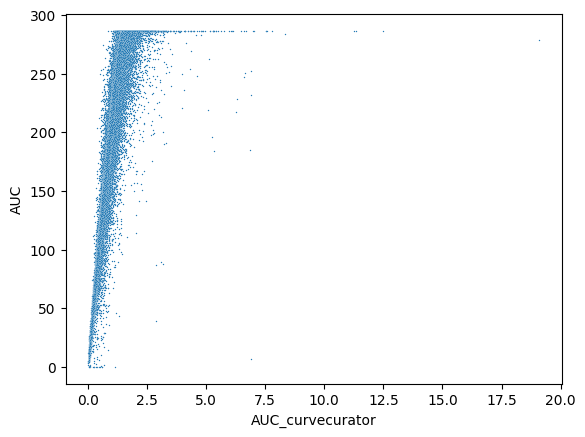

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# checks out because they measure AUC=area under the dose response curve, we measure AUC=area under the dose viability curve
sns.scatterplot(viability_df, x="AUC_curvecurator", y="AUC", s=1)

In [40]:
# we might have to divide by the number of measurements
raw_df['measurements'] = raw_df.groupby(["dbgap_subject_id", "inhibitor", "repl"], as_index=False)["inhibitor"].cumcount()
repl_df = raw_df[['dbgap_subject_id', 'inhibitor', 'measurements']].drop_duplicates()
repl_df[['dbgap_subject_id', 'inhibitor']] = repl_df[['dbgap_subject_id', 'inhibitor']].astype(str) 
repl_df.head()

,dbgap_subject_id,inhibitor,measurements
0,2262,Cytarabine,0
1,2262,Cytarabine,1
2,2262,Cytarabine,2
3,2262,Cytarabine,3
4,2262,Cytarabine,4


In [36]:
viability_df = viability_df.merge(repl_df, left_on=['cell_line_name', 'drug_name'], right_on=['dbgap_subject_id', 'inhibitor'])
viability_df['AUC_corrected'] = viability_df['AUC']/viability_df['max_repl']

<Axes: xlabel='AUC_curvecurator', ylabel='AUC_corrected'>

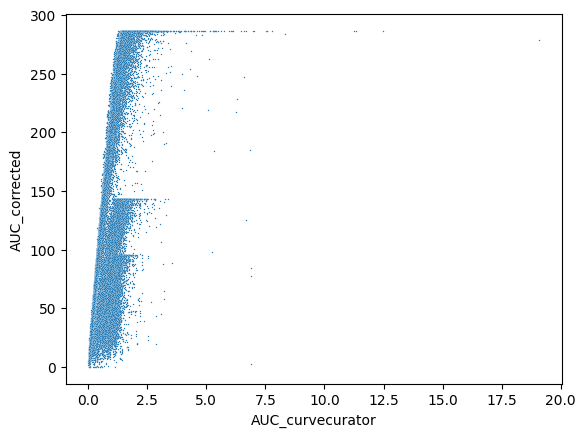

In [37]:
sns.scatterplot(viability_df, x="AUC_curvecurator", y="AUC_corrected", s=1)

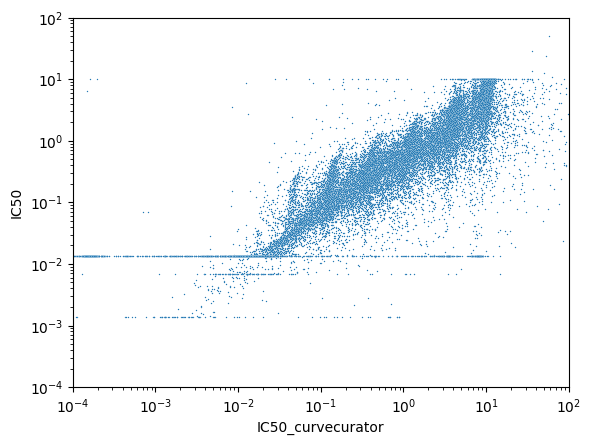

In [27]:
sns.scatterplot(viability_df, x="IC50_curvecurator", y="IC50", s=1)
plt.xlim(1e-4, 1e2)
plt.ylim(1e-4, 1e2)
plt.xscale('log')
plt.yscale('log')

In [ ]:
# create cell line names file
response_data = data.merge(df_map, left_on="inhibitor", right_on="drug_name_beataml", how="left")
response_data["LN_IC50"] = response_data["ic50"]
response_data.drop(columns=["ic50", "drug_name_beataml", "status", "paper_inclusion"], inplace=True)
response_data["cell_line_name"] = response_data["dbgap_subject_id"].astype(str)

cell_line_names = response_data.drop_duplicates("cell_line_name")[["cell_line_name"]]
cell_line_names["Cellosaurus_id"] = pd.NA
cell_line_names["tissue"] = "Blood"
cell_line_names.to_csv("cell_line_names.csv", index=False)

In [ ]:
# create gene expression feature file
gene_exp = pd.read_csv("other/beataml_waves1to4_norm_exp_dbgap.txt", sep="\t", index_col=0)

gene_exp_processed = gene_exp
gene_exp_processed =  gene_exp_processed.reset_index().drop(columns=["stable_id", "description", "biotype"]).set_index("display_label")
gene_exp_processed = gene_exp_processed.T
map_rna_id_to_cl_name = {rna_ind: sub_ind for sub_ind, rna_ind in zip(response_data["cell_line_name"], response_data["dbgap_rnaseq_sample"])}
#remap index
gene_exp_processed.index = [map_rna_id_to_cl_name.get(ind, pd.NA) for ind in gene_exp_processed.index]
gene_exp_processed =  gene_exp_processed.drop(pd.NA)
gene_exp_processed.to_csv("gene_expression.csv", index=True)

In [ ]:
# create drug names file
drug_names = df_map[["drug_name_beataml", "drug_name", "pubchem_id"]]
#if pubchemid is NA, use drug_name
drug_names["pubchem_id"] = drug_names["pubchem_id"].replace("", pd.NA)
drug_names["pubchem_id"] = drug_names["pubchem_id"].replace(" ", pd.NA)

drug_names["pubchem_id"] = drug_names["pubchem_id"].fillna(drug_names["drug_name"])

drug_names.to_csv("drug_names.csv", index=False)

In [ ]:
#create fingerprints
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

# df has columns: pubchem_id, canonical_smiles
drug_smiles = pd.read_csv("drug_smiles.csv")

df = drug_smiles.copy()

out_dir = "drug_fingerprints"
os.makedirs(out_dir, exist_ok=True)

def morgan_bits(smiles, n_bits, radius=2):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return np.full(n_bits, np.nan)  # keep shape even if invalid
    fp = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

sizes = [64, 128, 256, 512, 1024, 2048]

for n in sizes:
    print(f"computing {n}-bit fingerprints")
    # compute and stack into a DataFrame (rows = bit positions, cols = pubchem_id)
    fp_matrix = {}
    for pid, smi in zip(df["pubchem_id"], df["canonical_smiles"]):
        fp_matrix[pid] = morgan_bits(smi, n)
    fp_df = pd.DataFrame(fp_matrix)  # index 0..n-1, columns = pubchem_id
    fp_df.to_csv(f"{out_dir}/pubchem_id_to_demorgan_{n}_map.csv", index=False)


In [ ]:
# rename genes in gene expression file  to correct symbols
ge = pd.read_csv("gene_expression.csv", index_col=0)
genes = list(ge.columns)
new_gene_names = {
    "AARS": "AARS1",
    "EPRS": "EPRS1",
    "FAM57A": "TLCD3A",
    "FAM69A": "DIPK1A",
    "H2AFV": "H2AZ2",
    "HIST1H2BK": "H2BC12",
    "HIST2H2BE": "H2BC21",
    "KIAA0100": "BLTP2",
    "KIAA0355": "GARRE1",
    "NARFL": "CIAO3",
    "PAPD7": "TENT4A",
    "SKIV2L": "SKIC2",
    "TSTA3": "GFUS",
    "WDR61": "SKIC8",
    "WRB": "GET1",
}
new_genes = [new_gene_names.get(g, g) for g in genes]
ge.columns = new_genes
landmark_genes  = pd.read_csv("gene_lists/landmark_genes.csv", index_col=0)
set(landmark_genes["Symbol"]) - set(new_genes)
#save again
ge.index.name = "cell_line_name"
ge.to_csv("gene_expression.csv", index=True)

In [ ]:
# correct pubchem ids in BeatAML2.csv
import pandas as pd

d = pd.read_csv("BeatAML2.csv")
d["pubchem_id"] = d["pubchem_id"].astype(str).str.replace(".0", "", regex=False)

d.loc[d["drug_name"] == "MEK1/2 Inhibitor", "pubchem_id"] = "MEK1/2 Inhibitor"
d.loc[d["drug_name"] == "JQ12", "pubchem_id"] = "JQ12"

d.to_csv("BeatAML2.csv", index=False)
